In [1]:
from math import sqrt
import pandas as pd
import numpy as np

from sklearn.calibration import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

from xgboost import XGBRegressor
from sklearn.svm import SVR
import tensorflow as tf


#Graphing Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

# Data Preprocessing

In [2]:
data=pd.read_csv('bmw_pricing_challenge.csv')
X=data.drop(columns=['price'])
Y=data['price'] #target variable

# data-target split
data=pd.read_csv('bmw_pricing_challenge.csv')
X=data.drop(columns=['price'])
Y=data['price'] #target variable

In [3]:
data.head()

,maker_key,model_key,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,BMW,118,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,BMW,M4,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,BMW,320,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,BMW,420,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,BMW,425,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [4]:
data.describe()

,mileage,engine_power,price
count,4.843000e+03,4843.00000,4843.000000
mean,1.409628e+05,128.98823,15828.081767
std,6.019674e+04,38.99336,9220.285684
min,-6.400000e+01,0.00000,100.000000
25%,1.029135e+05,100.00000,10800.000000
50%,1.410800e+05,120.00000,14200.000000
75%,1.751955e+05,135.00000,18600.000000
max,1.000376e+06,423.00000,178500.000000


In [5]:
data.dtypes[data.dtypes!='object']

mileage         int64
engine_power    int64
feature_1        bool
feature_2        bool
feature_3        bool
feature_4        bool
feature_5        bool
feature_6        bool
feature_7        bool
feature_8        bool
price           int64
dtype: object

In [6]:
# Cleaning Data

data.drop(['maker_key','model_key'],axis=1,inplace=True)
data.drop_duplicates(inplace=True)
data = data.dropna()


pd.DataFrame(data.isnull().sum().sort_values(ascending=False)).head(20)
print('Missing Values:'+ str(data.isnull().sum().sum()))
data.head()

Missing Values:0


,mileage,engine_power,registration_date,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,sold_at
0,140411,100,2012-02-01,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2018-01-01
1,13929,317,2016-04-01,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2018-02-01
2,183297,120,2012-04-01,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2018-02-01
3,128035,135,2014-07-01,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2018-02-01
4,97097,160,2014-12-01,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2018-04-01


In [7]:
count=0
while count==0:
    # Add days between registration date and sold_at
    data['sold_at'] = pd.to_datetime(data['sold_at'])
    data['registration_date'] = pd.to_datetime(data['registration_date'])
    data['time_to_sale'] = data['sold_at'] - data['registration_date']
    
    # Add registration year & time_to_sale_days
    data['registration_year'] = data['registration_date'].dt.year.astype('int64')
    data['year_sold']=data['sold_at'].dt.year.astype('int64')
    data['time_to_sale_days']=data['time_to_sale'].dt.days.astype('int64')
    data=data.drop(columns=['registration_date','time_to_sale','sold_at'])
    count+=1

data


,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,registration_year,year_sold,time_to_sale_days
0,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2012,2018,2161
1,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2016,2018,671
2,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2012,2018,2132
3,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2014,2018,1311
4,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2014,2018,1217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,39743,110,diesel,black,van,False,True,False,False,False,False,True,False,14600,2015,2018,1035
4839,49832,100,diesel,grey,van,False,True,False,False,False,False,True,True,17500,2015,2018,1157
4840,19633,110,diesel,grey,van,False,True,False,False,False,False,True,True,17000,2015,2018,1066
4841,27920,110,diesel,brown,van,True,True,False,False,False,False,True,True,22700,2016,2018,883


# Feature Engineering

## Label Encoding

In [8]:
def encode_labels(data,return_labelEncoded_colums=False):
    enc = LabelEncoder()
    label_encoded_columns=[]
    for col in data.columns:
        if data[col].dtypes != 'int64':
            data[col]= enc.fit_transform(data[col])
            label_encoded_columns.append(col)
    if return_labelEncoded_colums==False:
        return data
    else:
        return label_encoded_columns,data

In [9]:
data.head()

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,registration_year,year_sold,time_to_sale_days
0,140411,100,diesel,black,convertible,True,True,False,False,True,True,True,False,11300,2012,2018,2161
1,13929,317,petrol,grey,convertible,True,True,False,False,False,True,True,True,69700,2016,2018,671
2,183297,120,diesel,white,convertible,False,False,False,False,True,False,True,False,10200,2012,2018,2132
3,128035,135,diesel,red,convertible,True,True,False,False,True,True,True,True,25100,2014,2018,1311
4,97097,160,diesel,silver,convertible,True,True,False,False,False,True,True,True,33400,2014,2018,1217


# Data Visualization

## Removing Outliers

Text(0, 0.5, 'Frequency')

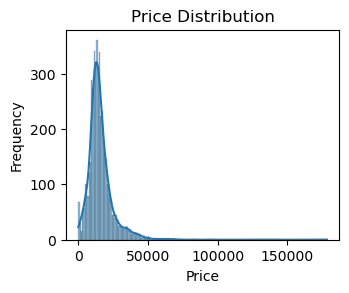

In [10]:
#Price Distribution
plt.figure(figsize=(12, 6))
plt.subplot(2, 3, 1)
sns.histplot(data['price'], kde=True)
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')

In [11]:
#Correlation Analysis
data_copy = data.copy()
data_label_encoded=encode_labels(data_copy)
price_corr = data_label_encoded.corrwith(data_label_encoded.price).reset_index().rename(columns={'index': 'features', 0: 'values'})
price_corr['values'] = price_corr['values'].apply(lambda x : abs(x))
price_corr.sort_values(by='values', inplace=True)
price_corr.style.background_gradient(cmap='viridis')

D:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
D:\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


,features,values
11,feature_7,0.005337
3,paint_color,0.016292
2,fuel,0.017325
10,feature_6,0.210966
6,feature_2,0.246808
7,feature_3,0.251275
9,feature_5,0.261768
4,car_type,0.267482
5,feature_1,0.269320
0,mileage,0.409564


In [12]:
data.drop(columns=['feature_7','paint_color','fuel'])

,mileage,engine_power,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_8,price,registration_year,year_sold,time_to_sale_days
0,140411,100,convertible,True,True,False,False,True,True,False,11300,2012,2018,2161
1,13929,317,convertible,True,True,False,False,False,True,True,69700,2016,2018,671
2,183297,120,convertible,False,False,False,False,True,False,False,10200,2012,2018,2132
3,128035,135,convertible,True,True,False,False,True,True,True,25100,2014,2018,1311
4,97097,160,convertible,True,True,False,False,False,True,True,33400,2014,2018,1217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4838,39743,110,van,False,True,False,False,False,False,False,14600,2015,2018,1035
4839,49832,100,van,False,True,False,False,False,False,True,17500,2015,2018,1157
4840,19633,110,van,False,True,False,False,False,False,True,17000,2015,2018,1066
4841,27920,110,van,True,True,False,False,False,False,True,22700,2016,2018,883


Text(0, 0.5, 'Price')

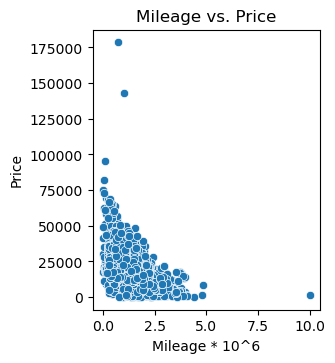

In [13]:
#Mileage vs. Price Scatter Plot
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 3)
sns.scatterplot(x=(data['mileage']/100000), y=data['price'])
plt.title('Mileage vs. Price')
plt.xlabel('Mileage * 10^6')
plt.ylabel('Price')

In [14]:
data[data['mileage']>1000000]

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,registration_year,year_sold,time_to_sale_days
3732,1000376,90,diesel,black,subcompact,True,False,False,False,False,False,True,False,1400,2005,2018,4840


In [15]:
data[data['price']>80000]

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,registration_year,year_sold,time_to_sale_days
90,12402,170,hybrid_petrol,grey,coupe,True,True,False,False,False,False,False,True,95200,2016,2018,821
4146,2970,423,petrol,red,suv,True,True,True,False,False,False,True,True,82400,2016,2018,730
4684,103222,140,diesel,grey,suv,True,True,False,False,True,False,True,True,142800,2014,2018,1461
4753,72515,135,diesel,blue,suv,False,False,True,False,False,False,False,True,178500,2013,2018,1979


In [16]:
# Removing Outliers
data=data.drop(index=[90,4684,4753,3732])

Text(0, 0.5, 'Price')

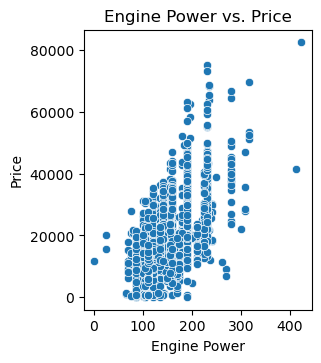

In [17]:
#Engine Power vs. Price Scatter Plot
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 4)
sns.scatterplot(x=data['engine_power'], y=data['price'])
plt.title('Engine Power vs. Price')
plt.xlabel('Engine Power')
plt.ylabel('Price')

In [18]:
data[(data['engine_power']>350) | (data['engine_power']<50) ]

,mileage,engine_power,fuel,paint_color,car_type,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,price,registration_year,year_sold,time_to_sale_days
1796,152328,25,hybrid_petrol,black,hatchback,False,True,False,False,False,False,True,True,20300,2014,2018,1520
1925,152470,25,hybrid_petrol,black,hatchback,False,True,False,False,False,False,True,True,15500,2014,2018,1489
3601,150187,412,petrol,white,sedan,True,True,True,False,True,True,True,True,41600,2012,2018,2404
3765,81770,0,diesel,white,suv,False,False,False,False,False,False,False,False,11700,2014,2018,1247
4146,2970,423,petrol,red,suv,True,True,True,False,False,False,True,True,82400,2016,2018,730


In [19]:
# Removing Outliers
data=data.drop(index=[3601,4146,1925,1796,3765])

Text(0, 0.5, 'Count')

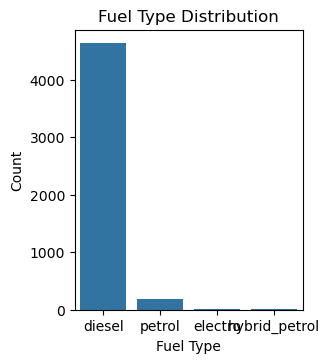

In [20]:
#Fuel Type Distribution
plt.figure(figsize=(10, 8))
plt.subplot(2, 3, 5)
sns.countplot(data=data, x='fuel')
plt.title('Fuel Type Distribution')
plt.xlabel('Fuel Type')
plt.ylabel('Count')


# Predictions with ML Algorithms

In [21]:
def regression(y_test_, y_pred_, print_ =False):
    mse=mean_squared_error(y_test_, y_pred_)
    rmse= sqrt(mse)
    mae= mean_absolute_error(y_test_, y_pred_)
    mape=mean_absolute_percentage_error(y_test_, y_pred_)
    r2=r2_score(y_test_, y_pred_)
    
    if print_:
        print(f"mse: {mse}")
        print(f"rmse: {rmse}")    
        print(f"mae: {mae}")
        print(f"mape: {mape}")
        print(f"r2_score {r2}")

    return r2

In [22]:
def labelEncode_and_Standardize(mydata):
    
    #Label encoding data
    mydata=encode_labels(mydata)
    label_encoded_columns,_=encode_labels(mydata,return_labelEncoded_colums=True)
    label_encoded_columns.append('price')
    non_label_encoded_columns=[col for col in data.columns if col not in label_encoded_columns]


    # Data Standardization
    scaler=StandardScaler()
    mydata[non_label_encoded_columns] = scaler.fit_transform(mydata[non_label_encoded_columns])
    mydata[non_label_encoded_columns] = scaler.fit_transform(mydata[non_label_encoded_columns])
    return mydata

In [23]:
def calculate_linear_regression(X,y,print_=False):
    #Train-Test split
    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42)

    #Label Encode and Standardize X_train & X_test
    X_train,X_test=labelEncode_and_Standardize(X_train),labelEncode_and_Standardize(X_test)
    
    linear_regression = LinearRegression()
    linear_regression.fit(X_train,y_train)
    y_pred=linear_regression.predict(X_test)
    return regression(y_test,y_pred,print_)

In [29]:
def calculate_decision_tree(X, y, print_=False):
    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    
    #Label Encoding
    X_train, X_test=encode_labels(X_train), encode_labels(X_test)

    
    # Training the model
    tree_regressor = DecisionTreeRegressor(random_state=42)
    tree_regressor.fit(X_train, y_train)
    
    # Prediction
    y_pred = tree_regressor.predict(X_test)
    return regression(y_test, y_pred, print_)

In [25]:
def calculate_random_forest(X, y, print_=False):
    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #Label Encoding
    X_train, X_test=encode_labels(X_train), encode_labels(X_test)
    
    # Training the model
    forest_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
    forest_regressor.fit(X_train, y_train)
    
    # Prediction
    y_pred = forest_regressor.predict(X_test)
    return regression(y_test, y_pred, print_)

In [26]:
def calculate_xgboost(X, y, print_=False):
    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    #Label Encoding
    X_train, X_test=encode_labels(X_train), encode_labels(X_test)
    
    # Training the model
    xgb_regressor = XGBRegressor(random_state=42)
    xgb_regressor.fit(X_train, y_train)
    
    # Prediction
    y_pred = xgb_regressor.predict(X_test)
    return regression(y_test, y_pred, print_)


In [27]:
def calculate_neural_network(X, y, print_=False):
    # Train-Test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    #Label Encode and Standardize X_train & X_test
    X_train,X_test=labelEncode_and_Standardize(X_train),labelEncode_and_Standardize(X_test)
    
    # Model definition
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(56, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(48, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(40, activation='relu', input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(1)  # Single output for regression
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    
    # Training
    model.fit(X_train, y_train, epochs=50, verbose=0, batch_size=32)
    
    # Prediction
    y_pred = model.predict(X_test).flatten()
    return regression(y_test, y_pred, print_)

In [30]:
ml_algorithms={'Linear Regression':calculate_linear_regression,
                    'Decision Tree Regressor':calculate_decision_tree,
                    'Random Forest Regressor':calculate_random_forest,
                    'XGBoost':calculate_xgboost,
                    'Neural Network':calculate_neural_network}
def main():
    
    def best_ml_algo(algorithms,X,y,print_=True):
        best_algo = None
        best_algo_name = None
        best_r2 = float('-inf')
        for algo_name,algo in zip(algorithms.keys(),algorithms.values()):
            print(algo_name)
            print(algo(X,y,print_=True),'\n')
            r2=algo(X,y,print_=False)
            if (r2>best_r2):
                best_algo,best_algo_name,best_r2=algo,algo_name,r2

        print(f'\n\nAlgorithm With Highest R2 Score is:{best_algo_name}with R2-Score={best_r2:.2f} ')
        
    
    X=data.drop(columns=['price'], axis=1).copy()
    y=data.price

    
    best_ml_algo(ml_algorithms,X,y,print_=True)


if __name__ == "__main__":
    main()

Linear Regression
mse: 19671873.873833418
rmse: 4435.298622847555
mae: 3062.468229154038
mape: 0.6728311585525012
r2_score 0.7204165866761979
0.7204165866761979 

Decision Tree Regressor
mse: 20210916.60923501
rmse: 4495.655303649848
mae: 2885.8718125430737
mape: 0.6377290905296715
r2_score 0.7127555265831155
0.7127555265831155 

Random Forest Regressor
mse: 11042179.04755341
rmse: 3322.977437111695
mae: 2099.724328049621
mape: 0.5291494381835609
r2_score 0.8430647670655305
0.8430647670655305 

XGBoost
mse: 11570707.580990538
rmse: 3401.5742797990665
mae: 2148.3152215538316
mape: 0.5457855173388023
r2_score 0.8355531692504883
0.8355531692504883 

Neural Network


D:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
mse: 13669512.141163053
rmse: 3697.2303337989442
mae: 2445.345339942685
mape: 0.5390028037228605
r2_score 0.8057242035865784
0.8057242035865784 



D:\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


Algorithm With Highest R2 Score is:Random Forest Regressorwith R2-Score=0.84 


In [50]:
#Using the model with the highest R2 Score to 

def predict_car_price(input_features, model):
    
    input_df = pd.DataFrame([input_features])

    for col in data.columns:
        if col not in input_df.columns:
            input_df[col] = None  # give the missing columns a None value
    
    # Replace missing values with the mean of the respective column in the data
    for col in data.columns:
        if input_df[col].isnull().any():
            input_df[col].fillna(data[col].mean(), inplace=True)

    
    input_df = input_df[data.columns]

    
    # Predict the price
    predicted_price = model.predict(input_df)[0]
    
    return predicted_price



In [ ]:
input_features = {
    'mileage': 30000,
    'engine_power': 220,
    'fuel': 'Petrol',
    'paint_color': 'White',
    'car_type': 'SUV',
    'feature_1': True,
    'feature_2': True,
    'feature_3': False,
    'feature_4': True,
    'feature_5': False,
    'feature_6': True,
    'feature_7': False,
    'feature_8': True,
    'price': 45000,
    'registration_year': 2018,
    'year_sold': 2022,
    'time_to_sale_days': 200,
}

input_features=pd.DataFrame([input_features])

input_features_=encode_labels(input_features)
scaler=StandardScaler()
non_label_encoded_columns=['mileage','engine_power','registration_year','year_sold','time_to_sale_days']
input_features_[non_label_encoded_columns]=scaler.fit_transform(input_features_[non_label_encoded_columns])

# Predict price
predicted_price = predict_car_price([input_features_], calculate_random_forest)
print(f"Predicted Price: ${predicted_price:.2f}")